In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import drive
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam

In [65]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [66]:
def splits(dataset,TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset  = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [67]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)


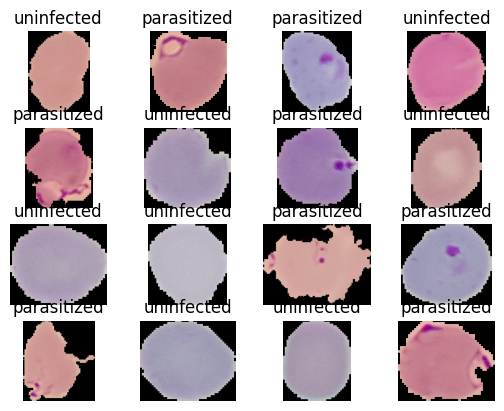

In [68]:
## data visualization
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [69]:
IM_SIZE = 224
def resize_rescale(image, lable):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,lable

In [72]:
## data Preprocessing
train_dataset = train_dataset.map(resize_rescale)
val_dataset  = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [73]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [74]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


In [12]:
model = tf.keras.Sequential([
    InputLayer(input_shape =(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size =3, strides = 1, padding = 'valid', activation= 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters = 16, kernel_size =3, strides = 1, padding = 'valid', activation= 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │      46,657,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,762,737 (178.39 MB)

 Trainable params: 46,760,493 (178.38 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.7597 - loss: 0.4976 - val_accuracy: 0.9245 - val_loss: 0.2277
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9320 - loss: 0.2061 - val_accuracy: 0.7993 - val_loss: 0.3794
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 47s 68ms/step - accuracy: 0.9396 - loss: 0.1856 - val_accuracy: 0.9521 - val_loss: 0.2775
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 75ms/step - accuracy: 0.9436 - loss: 0.1700 - val_accuracy: 0.9554 - val_loss: 0.2872
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 49s 71ms/step - accuracy: 0.9457 - loss: 0.1632 - val_accuracy: 0.7158 - val_loss: 0.4454
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 75ms/step - accuracy: 0.9103 - loss: 0.2474 - val_accuracy: 0.9437 - val_loss: 0.3029
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 66ms/step - accuracy: 0.9451 - loss: 0.1736 - val_accuracy: 0.9477 - val_loss: 0.3787
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 85s 71ms/step - accuracy: 0.9533 - loss: 0.1480 - 

In [16]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9368 - loss: 0.3093


[0.30979785323143005, 0.9387015104293823]

In [17]:
model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


0.9976113

In [23]:
def parasite_or_not(X):
  if(X<0.5):
    return 'P'
  else:
    return 'U'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


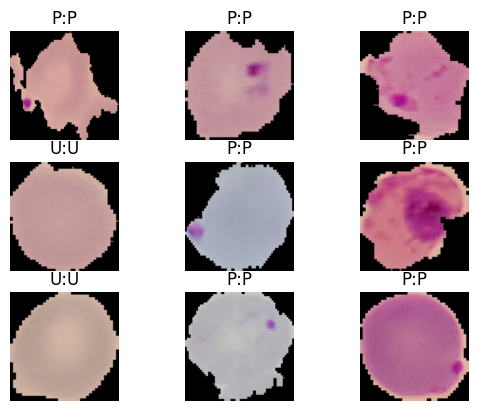

In [24]:
for i, (image,label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) +":" + str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')

In [27]:
#Saving to and Loading from Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [53]:
model.save('model.h5')

In [60]:
## Functional API
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name= 'Input Image')

x = Conv2D(filters = 6, kernel_size =3, strides = 1, padding = 'valid', activation= 'relu')(func_input)
x =  BatchNormalization()(x)
x =  MaxPool2D(pool_size=2, strides=2)(x)

x=  Conv2D(filters = 16, kernel_size =3, strides = 1, padding = 'valid', activation= 'relu')(x)
x=   BatchNormalization()(x)
x=  MaxPool2D(pool_size=2, strides=2)(x)

x=  Flatten()(x)

x=    Dense(1000, activation='relu')(x)
x=    BatchNormalization()(x)

x=   Dense(100, activation='relu')(x)
x=  BatchNormalization()(x)

func_output=  Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name='Lenet_Model')
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │      46,657,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,762,737 (178.39 MB)

 Trainable params: 46,760,493 (178.38 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [61]:
#Model Training
lenet_model_func.compile(optimizer=Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(), metrics=['accuracy'])

In [62]:
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 60s 78ms/step - accuracy: 0.7637 - loss: 0.5182 - val_accuracy: 0.9289 - val_loss: 0.2224
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 69ms/step - accuracy: 0.9291 - loss: 0.2109 - val_accuracy: 0.9151 - val_loss: 0.3453
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.7486 - loss: 0.4932 - val_accuracy: 0.5074 - val_loss: 6.3751
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8678 - loss: 0.3242 - val_accuracy: 0.4944 - val_loss: 1.9479
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.9229 - loss: 0.2191 - val_accuracy: 0.8955 - val_loss: 0.2970
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.9332 - loss: 0.2004 - val_accuracy: 0.8236 - val_loss: 0.3520
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 47s 68ms/step - accuracy: 0.9288 - loss: 0.2055 - val_accuracy: 0.5034 - val_loss: 1.5005
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9366 - loss: 0.1893 - 

In [75]:
lenet_model_func.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9393 - loss: 1.3104


[1.6264995336532593, 0.9365252256393433]

In [78]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters*2, kernel_size= kernel_size, strides= strides,padding=  padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1  = MaxPool2D(pool_size= pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size= kernel_size, strides= strides,padding=  padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size= pool_size, strides=2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)
    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)